In [1]:
"""@author: FLOWHYDRO Consulting Spa"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline
register_matplotlib_converters()
import scipy.stats as stats
from plotnine import ggplot, aes, geom_histogram, geom_density, geom_qq, facet_wrap
from plotnine import *
import matplotlib.dates as mdates

In [2]:
def load_excel_data(file_path: str) -> pd.DataFrame:
    """Load data from an Excel file.

    Args:
        file_path: Path to the Excel file.

    Returns:
        DataFrame containing the loaded data.
    """
    df = pd.read_excel(file_path)
    print(df)
    return df

In [3]:
file_path = r"C:\Kedro_Project_Lab\ofertasalmuera\data\01_raw\Q_Medio_Mensual_filtrado_New_Input_13032024.xlsx"
df_input = load_excel_data(file_path)

         Origen    FECHA_D  Qmedio_mensual_l/s
0      ARPES-01 2014-01-01            7.469478
1      ARPES-01 2014-02-01            7.236663
2      ARPES-01 2014-03-01            7.484759
3      ARPES-01 2014-04-01            8.274160
4      ARPES-01 2014-05-01            7.291134
...         ...        ...                 ...
33714   XP17-05 2023-11-01            0.220853
33715   XP17-05 2023-12-01            0.190849
33716   XP17-05 2024-01-01            0.371406
33717   XP17-05 2024-02-01            0.341201
33718   XP17-05 2024-03-01            0.325153

[33719 rows x 3 columns]


In [4]:
# Función para transformar el DataFrame
def transformar_dataframe(df_input):
    """
    Transforma el DataFrame de entrada:
    - Convierte la columna 'FECHA_D' a formato datetime.
    - Selecciona y renombra columnas específicas.

    Args:
    df_input (pd.DataFrame): DataFrame de entrada.

    Returns:
    pd.DataFrame: DataFrame transformado.
    """
    # Verificar que las columnas necesarias existen en el DataFrame
    required_columns = ['Origen', 'FECHA_D', 'Qmedio_mensual_l/s']
    for col in required_columns:
        if col not in df_input.columns:
            raise ValueError(f"Columna '{col}' no encontrada en el DataFrame de entrada.")
    
    # Convertir la columna 'FECHA_D' a formato datetime
    df_input['FECHA_D'] = pd.to_datetime(df_input['FECHA_D'])

    # Crear una copia del DataFrame con las columnas seleccionadas
    df_input = df_input[['Origen', 'FECHA_D', 'Qmedio_mensual_l/s']].copy()
    
    # Eliminar espacios alrededor de los nombres de columnas por si acaso
    df_input.columns = df_input.columns.str.strip()

    # Renombrar las columnas
    df_input = df_input.rename(columns={
        'Origen': 'Pozo',
        'FECHA_D': 'Fecha',
        'Qmedio_mensual_l/s': 'Caudal (L/s)'
    })

    # Devolver el DataFrame transformado
    return df_input

In [5]:
df_train = transformar_dataframe(df_input)
print(df_train)

           Pozo      Fecha  Caudal (L/s)
0      ARPES-01 2014-01-01      7.469478
1      ARPES-01 2014-02-01      7.236663
2      ARPES-01 2014-03-01      7.484759
3      ARPES-01 2014-04-01      8.274160
4      ARPES-01 2014-05-01      7.291134
...         ...        ...           ...
33714   XP17-05 2023-11-01      0.220853
33715   XP17-05 2023-12-01      0.190849
33716   XP17-05 2024-01-01      0.371406
33717   XP17-05 2024-02-01      0.341201
33718   XP17-05 2024-03-01      0.325153

[33719 rows x 3 columns]


In [6]:
# Función para aplicar el filtro de Hampel con imputación opcional, ajustado para manejar bordes
def hampel_filter(ts, window_size, n_sigmas=2, imputation=True):
    n = len(ts)
    new_ts = ts.copy()
    k = 1.4826  # factor de normalización para la mediana absoluta de las desviaciones
    indices = []

    for i in range(n):
        start = max(0, i - window_size)
        end = min(n, i + window_size + 1)
        window = ts[start:end]
        median = np.median(window)
        diff = np.abs(window - median)
        MAD = np.median(diff)
        
        if MAD == 0:
            MAD = np.median(diff)  # Si MAD es 0, usar la mediana en su lugar

        if np.abs(ts[i] - median) > n_sigmas * k * MAD:
            if imputation:
                new_ts[i] = median  # Reemplazar outliers por la mediana
            indices.append(i)

    return new_ts, indices

In [7]:
# Aplicar el filtro de Hampel por cada pozo
def apply_hampel_by_well(df, window_size=7, n_sigmas=2, imputation=True):
    unique_wells = df['Pozo'].unique()
    results = []

    for well in unique_wells:
        well_df = df[df['Pozo'] == well].copy()
        ts = well_df['Caudal (L/s)']
        ts_imputed, outlier_indices = hampel_filter(ts, window_size, n_sigmas, imputation)
        
        well_df['Caudal_Filtrado'] = ts_imputed
        well_df['Outlier'] = False
        well_df.loc[well_df.index[outlier_indices], 'Outlier'] = True
        
        results.append(well_df)
    
    combined_df = pd.concat(results)
    return combined_df

In [8]:
# Convertir la columna 'Fecha' a tipo datetime y establecerla como índice
df_train['Fecha'] = pd.to_datetime(df_train['Fecha'])
df_train.set_index('Fecha', inplace=True)

# Aplicar el filtro y obtener el DataFrame combinado
result_df = apply_hampel_by_well(df_train)

# Guardar el resultado en un archivo CSV para verificación
result_df.to_excel('resultados_filtrados5.xlsx')

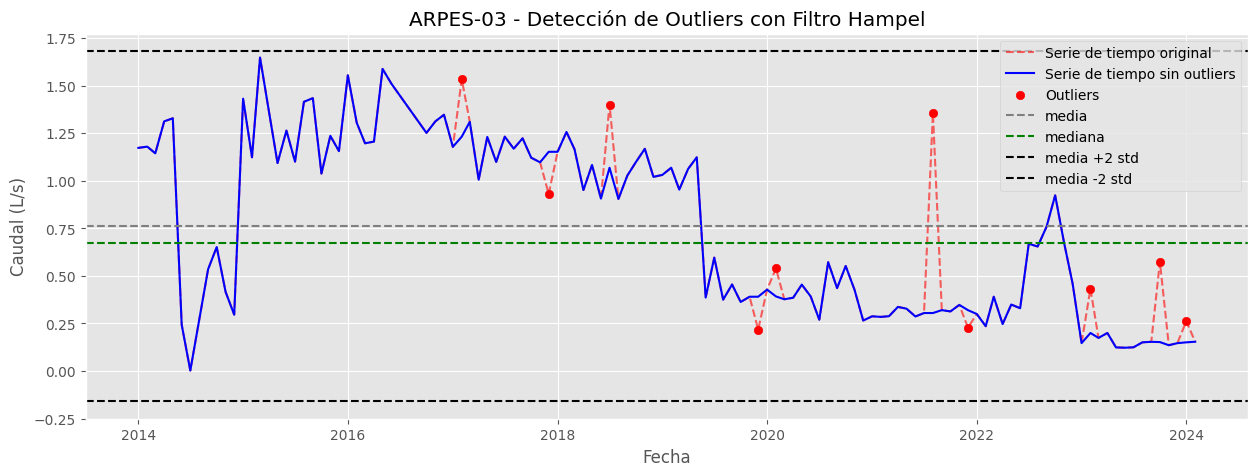

In [14]:
plt.style.use('ggplot')

# Visualizar los resultados para un pozo específico
well_name = 'ARPES-03'
if well_name in result_df['Pozo'].unique():
    well_df = result_df[result_df['Pozo'] == well_name]
    ts = well_df['Caudal (L/s)']
    ts_imputation = well_df['Caudal_Filtrado']
    outliers = well_df[well_df['Outlier'] == True]['Caudal (L/s)']

    # Calcular estadísticas
    mean = ts.mean()
    median = ts.median()
    std = ts.std()

    # Graficar los resultados
    plt.figure(figsize=(15, 5))  # Tamaño ajustado para mejor visualización

    # Graficar la serie de tiempo original con outliers
    plt.plot(ts.index, ts, 'r--', label='Serie de tiempo original', alpha=0.6)

    # Graficar la serie sin outliers segmentada y en azul (incluyendo valores imputados)
    plt.plot(ts.index, ts_imputation, 'b-', label='Serie de tiempo sin outliers')

    # Destacar los puntos outliers
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)

    # Líneas de media y desviaciones estándar
    plt.axhline(y=mean, color='gray', linestyle='--', label='media')
    plt.axhline(y=median, color='green', linestyle='--', label='mediana')
    plt.axhline(y=mean + 2 * std, color='k', linestyle='--', label='media +2 std')
    plt.axhline(y=mean - 2 * std, color='k', linestyle='--', label='media -2 std')

    # Ajustar los ejes automáticamente
    plt.autoscale()

    # Añadir etiquetas y título
    plt.xlabel('Fecha')
    plt.ylabel('Caudal (L/s)')
    plt.title(f'{well_name} - Detección de Outliers con Filtro Hampel')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No se encontraron datos para el pozo {well_name}")

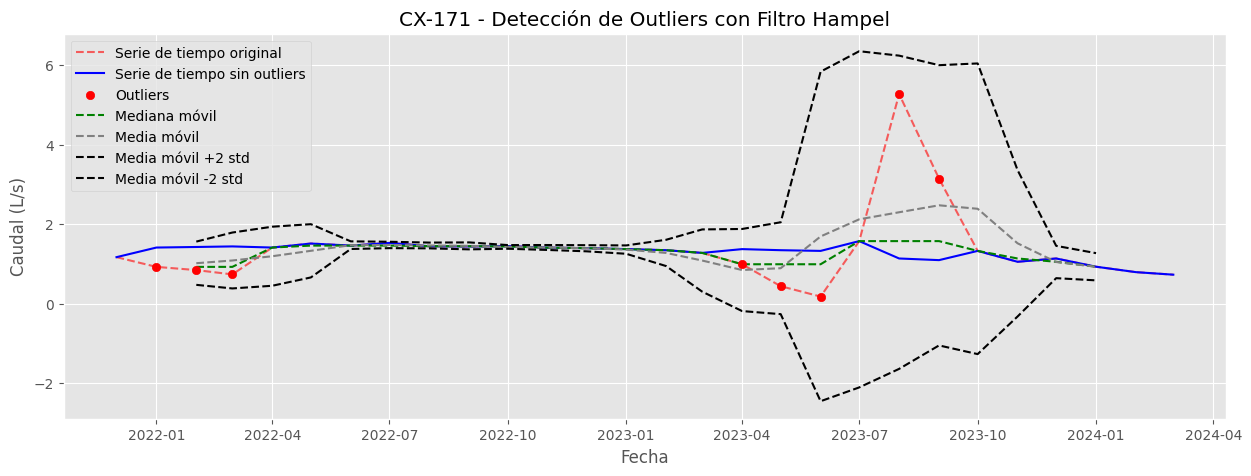

In [13]:
# Visualizar los resultados para un pozo específico
well_name = 'CX-171'
if well_name in result_df['Pozo'].unique():
    well_df = result_df[result_df['Pozo'] == well_name]
    ts = well_df['Caudal (L/s)']
    ts_imputation = well_df['Caudal_Filtrado']
    outliers = well_df[well_df['Outlier'] == True]['Caudal (L/s)']
    
    # Calcular la mediana móvil
    window_size = 5
    rolling_median = ts.rolling(window=window_size, center=True).median()
    rolling_mean = ts.rolling(window=window_size, center=True).mean()
    rolling_std = ts.rolling(window=window_size, center=True).std()

    # Graficar los resultados
    plt.figure(figsize=(15, 5))  # Tamaño ajustado para mejor visualización

    # Graficar la serie de tiempo original con outliers
    plt.plot(ts.index, ts, 'r--', label='Serie de tiempo original', alpha=0.6)

    # Graficar la serie sin outliers segmentada y en azul (incluyendo valores imputados)
    plt.plot(ts.index, ts_imputation, 'b-', label='Serie de tiempo sin outliers')

    # Destacar los puntos outliers
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)

    # Líneas de mediana móvil y desviaciones estándar móviles
    plt.plot(rolling_median.index, rolling_median, color='green', linestyle='--', label='Mediana móvil')
    plt.plot(rolling_mean.index, rolling_mean, color='gray', linestyle='--', label='Media móvil')
    plt.plot(rolling_mean.index, rolling_mean + 2 * rolling_std, color='k', linestyle='--', label='Media móvil +2 std')
    plt.plot(rolling_mean.index, rolling_mean - 2 * rolling_std, color='k', linestyle='--', label='Media móvil -2 std')

    # Ajustar los ejes automáticamente
    plt.autoscale()

    # Añadir etiquetas y título
    plt.xlabel('Fecha')
    plt.ylabel('Caudal (L/s)')
    plt.title(f'{well_name} - Detección de Outliers con Filtro Hampel')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No se encontraron datos para el pozo {well_name}")

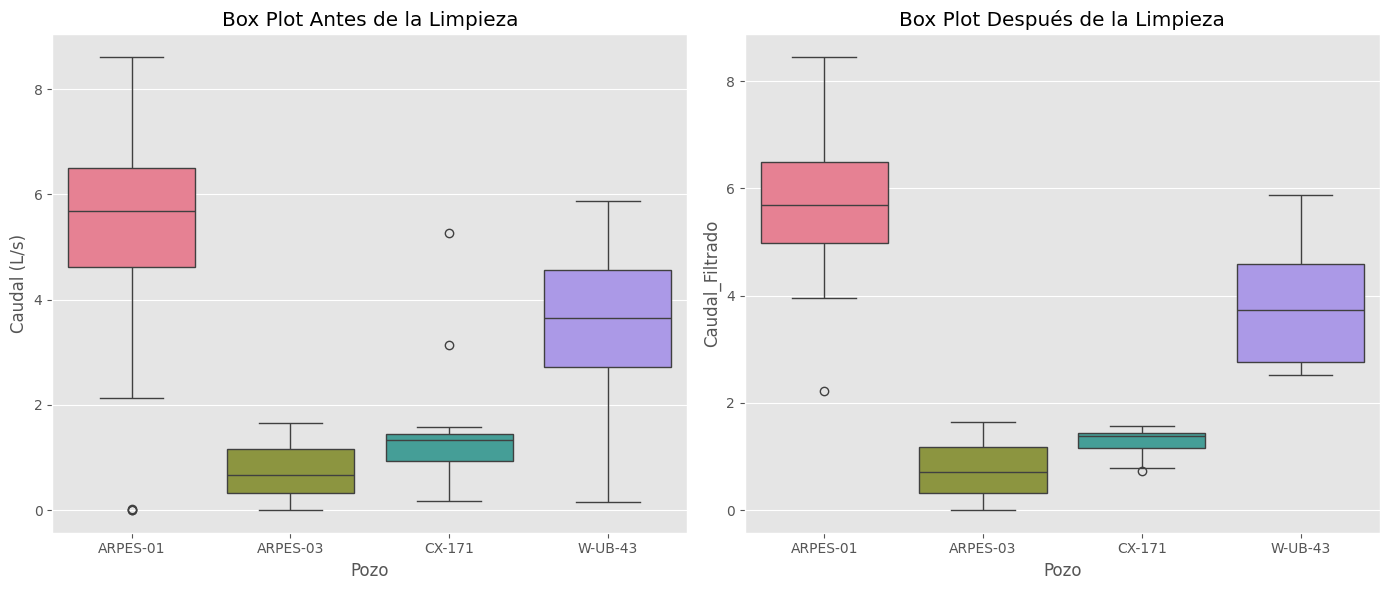

In [11]:
# Generar los box plots
plt.style.use('ggplot')

# Lista de pozos
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'W-UB-43']

# Generar la figura
plt.figure(figsize=(14, 6))

# Definir una paleta de colores
palette = sns.color_palette("husl", len(pozos))

# Box Plot antes de la limpieza
plt.subplot(1, 2, 1)
sns.boxplot(x='Pozo', y='Caudal (L/s)', data=result_df[result_df['Pozo'].isin(pozos)], palette=palette)
plt.title('Box Plot Antes de la Limpieza')

# Box Plot después de la limpieza
df_no_outliers_result = result_df[result_df['Outlier'] == False]
plt.subplot(1, 2, 2)
sns.boxplot(x='Pozo', y='Caudal_Filtrado', data=df_no_outliers_result[df_no_outliers_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Box Plot Después de la Limpieza')

# Mostrar los Box Plots
plt.tight_layout()
plt.show()

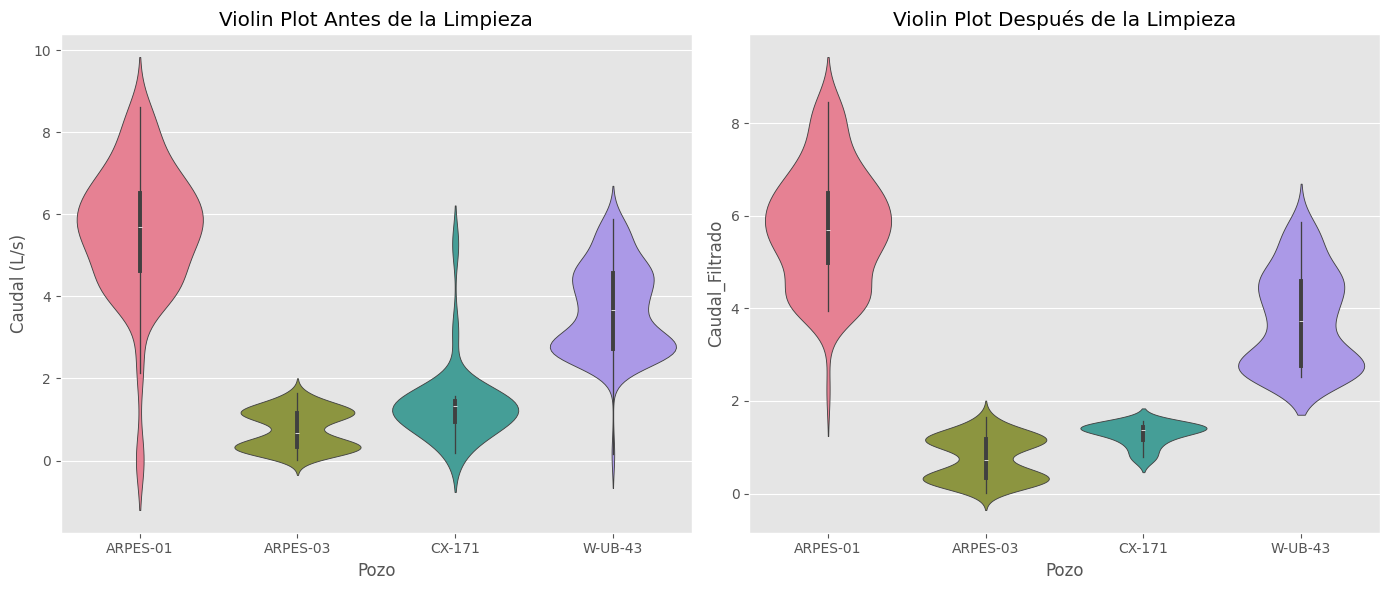

In [12]:
# Generar los violin plots
plt.style.use('ggplot')

# Lista de pozos
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'W-UB-43']

# Generar la figura
plt.figure(figsize=(14, 6))

# Definir una paleta de colores
palette = sns.color_palette("husl", len(pozos))

# Violin Plot antes de la limpieza
plt.subplot(1, 2, 1)
sns.violinplot(x='Pozo', y='Caudal (L/s)', data=result_df[result_df['Pozo'].isin(pozos)], palette=palette)
plt.title('Violin Plot Antes de la Limpieza')

# Violin Plot después de la limpieza
df_no_outliers_result = result_df[result_df['Outlier'] == False]
plt.subplot(1, 2, 2)
sns.violinplot(x='Pozo', y='Caudal_Filtrado', data=df_no_outliers_result[df_no_outliers_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Violin Plot Después de la Limpieza')

# Mostrar los Violin Plots
plt.tight_layout()
plt.show()